# **Premier League Predictions**

# **Contents**:
    1. Introduction
    2. Pre-model Exploration
        2.1 Validity Of Poisson Approximation
        2.2 ...
    3. Simulation Setup
    4. Predictive Model For Lambda
        4.1 Target Vector Construction
    5. Simulation Calls
        5.1 ...
    6. Reflection
    7. Archive

In [1]:
import json
import time

import numpy as np
import pandas as pd

from scipy.stats import poisson, skellam
from scipy.optimize import golden

import matplotlib.pyplot as plt
import seaborn as sns

# **1. Introduction**

# **2. Pre-model Exploration**

## **2.1 Validity Of Poisson Approximation**

I believe the likeihood of a certain number of goals being scored by each team could likely be modelled by the Poisson Distribution. This is because a football game satisfies several required assumptions of the poisson distribution such as having discrete events (somewhat) independent of each other, modelling rare events in a set interval of time, and having a (somewhat) constant goal rate.

I am going to investigate this through comparing Poisson Distribution goal likelihoods with betting odds for several games. In this, I am assuming that the betting markets are fully efficient (i.e I am taking them as a source of truth).

# **3. Simulation Setup**

In [3]:
class PremierLeagueSimulator:
    def __init__(self):
        """
        Initialize variables for later use.
        """
        self.schedule = None
        self.table = None

    
    def initialise_table(self):
        """
        Scrapes the current premier league table and stores it as a dataframe.
        """
        
        pass

    
    def set_schedule(self):
        """
        Scrapes the future schedule and stores it as a {DICTIONARY?} .

        I want to have gameweek after as well.
        """

        pass


    def match_outcome(home_xg, away_xg):
        """
        Returns the predicted goals for team 1 and predicted goals for team 2.

        Arguments:
        ----------
        home_xg:
            Predicted expected goals for team 1
        away_xg:
            Predicted expected goals for team 2

        Returns:
        --------
        [home_goals, away_goals]:
            List of goals for team 1 and goals for team 2
        """

        # Randomly sample from poisson distribution for home goals and away goals
        home_goals = poisson.rvs(home_xg) 
        away_goals = poisson.rvs(away_xg)

        return home_goals, away_goals

# **4. Predictive Model For Lambda**

## **4.1 Target Vector Construction**

### **4.1.1 Framing Of Challenge**

The target vector of the Model is the Poisson parameter, lambda for a single team in a game. This can be interpreted as: **what is the expected number of goals to be scored by a team in the upcoming game?** Thus, our target vector will be the expected number of goals scored for a single team and we will rely on historic data in our prediction of this.

For the historic data we're training our model on we are using a popular dataset {INSERT} which is frequently updated and contains {8??} seasons of premier league data. In this dataset each row is a historic game described by many features representing:
* **Match information:** Date, Time, Referee
* **Match statistics:** Goals, Shots, Shots On Target, etc.
* **Pre match betting odds:**  W/L/D odds, Under 2.5 odds, Asian Handicap odds, etc.

Our goal is to use this information to calculate lambda (expected number of goals scored by a team) for each team in every game. For this, we will rely heavily on the betting odds to derive the expected number of goals.

### **4.1.2 Derivation**

It's important to reiterate that throughout this whole section we are assuming:

$\text{N}_h \approx \text{Poisson}(\lambda_h)$,  $\text{N}_a \approx \text{Poisson}(\lambda_a)$ where $\text{N}_h$ and $\text{N}_a$ represents the number of goals scored by each team in a football game.

By definition, this means that $\text{N}_t \approx \text{Poisson}(\lambda_h) + \text{Poisson}(\lambda_a) \approx \text{Poisson}(\lambda_h + \lambda_a)$

If $\lambda_h + \lambda_a = \mu$ then $\text{N}_t \approx \text{Poisson}(\mu)$

This is important because one of the markets we have betting odds for is the under 2.5 total goals market and if we know $P(\text{N}_t<2.5)$ we can calculate $\mu$ using the poisson pmf:

$P(\text{N}_t<2.5)=e^{-\mu} + e^{-\mu}-\mu + \frac{1}{2}{e^{-\mu}}{\mu^{2}}={e^{-\mu}}(\frac{1}{2}\mu^2 + \mu + 1)$

$|{e^{-\mu}}(\frac{1}{2}\mu^2 + \mu + 1) - P(\text{N}_t<2.5)|$ gives the absolute difference between the Poisson pmf evaluation at a given $\lambda$ and the true probability. Essentially, the lambda value that minimises this function is the true lambda.

Lets observe this function across some realistic $P(\text{N}_t<2.5)$ values. As this function will be strictly quansi convex with a minimum at 0, we can additionally use standard univariate minimisation algorithms such as the golden section search to find $\mu$:

## REDO WITH 3 REAL GAMES INSTEAD

The mu value that minimises this function is 3.105378597072109


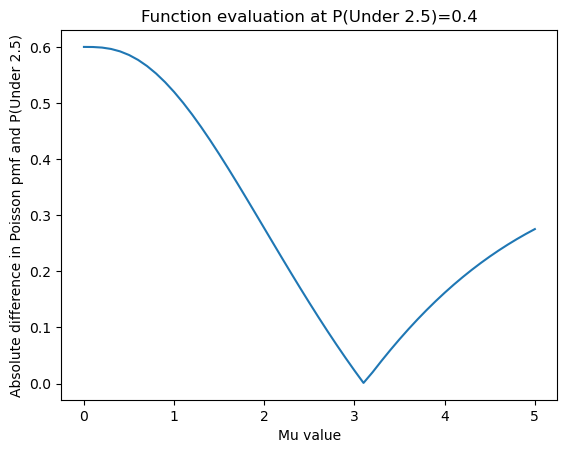

The mu value that minimises this function is 2.4759383122765253


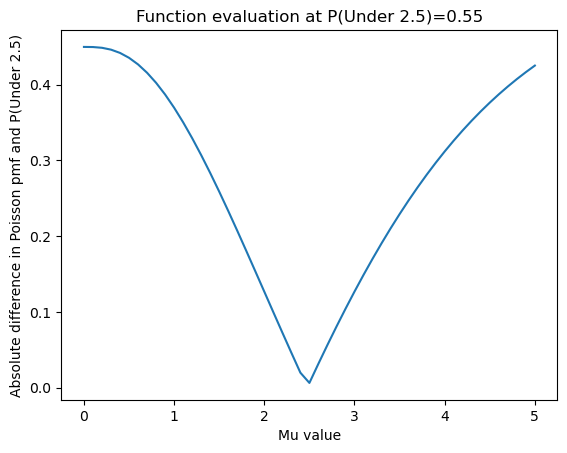

The mu value that minimises this function is 1.913775796048034


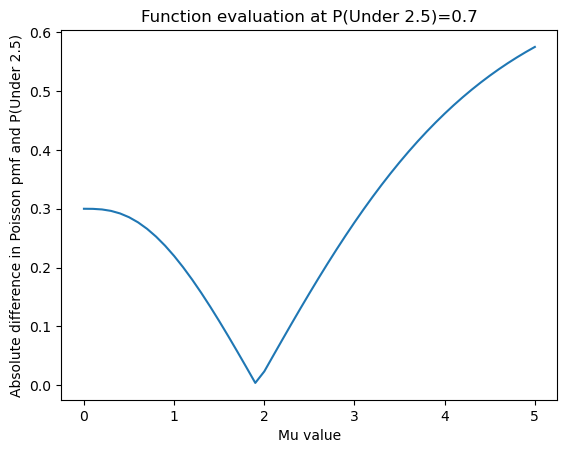

In [4]:
import numpy as np
from scipy.optimize import golden

U25_list = np.linspace(0.4, 0.7, 3)
lambda_range = np.linspace(0, 5, 51)
function_vals = []

for U25 in U25_list:
    for lam in lambda_range:
        function_vals.append(np.abs(np.exp(-lam)*(0.5*lam**2 + lam + 1) - U25))

    def pmf_difference_function(lam):
        return np.abs(np.exp(-lam)*(0.5*lam**2 + lam + 1) - U25)
    
    optimal_lam = golden(pmf_difference_function)
    print(f"The mu value that minimises this function is {optimal_lam}")
    plt.plot(lambda_range, function_vals)
    plt.title(f"Function evaluation at P(Under 2.5)={U25}")
    plt.xlabel("Mu value")
    plt.ylabel("Absolute difference in Poisson pmf and P(Under 2.5)")
    plt.show()

    function_vals = []

The mu value that minimises these function appears to be realistic for the number of goals expected in a football game which is encouraging. As these functions appear to be strictly quansi convex, I can use standard univariate minimisation techniques. I am therefore going to use the golden section search method to determine the value that minimises each function.

The mu value that minimises this function is 3.1053786027983756


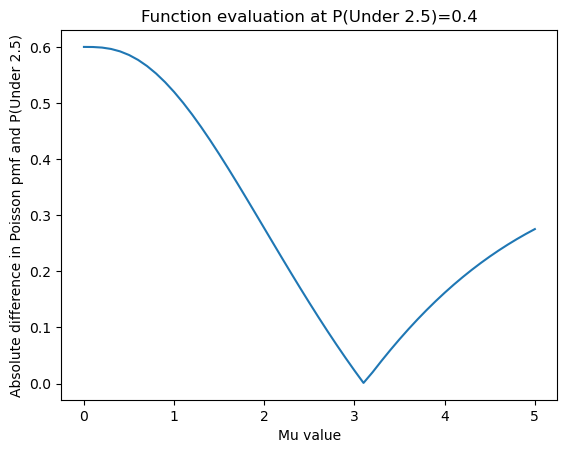

The mu value that minimises this function is 2.475938300377117


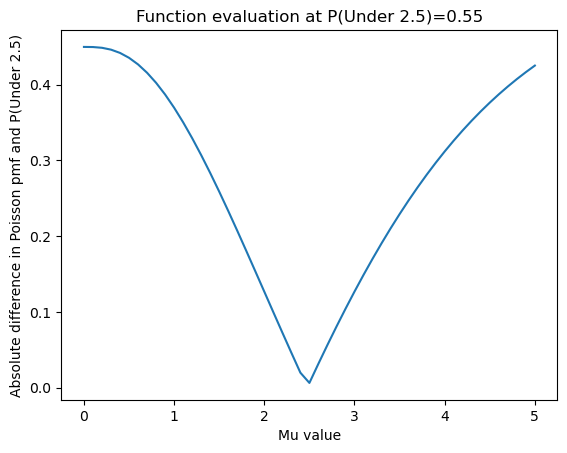

The mu value that minimises this function is 1.9137757865116072


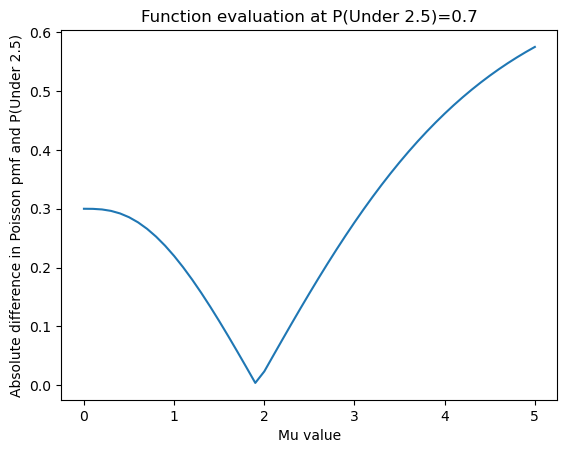

In [5]:
import numpy as np
from scipy.optimize import golden

U25_list = np.linspace(0.4, 0.7, 3)
mu_range = np.linspace(0, 5, 51)
function_vals = []

for U25 in U25_list:
    for mu in mu_range:
        function_vals.append(np.abs(np.exp(-mu)*(0.5*mu**2 + mu + 1) - U25))

    def poisson_difference_function(mu):
        return np.abs(np.exp(-mu)*(0.5*mu**2 + mu + 1) - U25)
    
    optimal_mu = golden(poisson_difference_function, brack=(0, 10))
    print(f"The mu value that minimises this function is {optimal_mu}")
    plt.plot(mu_range, function_vals)
    plt.title(f"Function evaluation at P(Under 2.5)={U25}")
    plt.xlabel("Mu value")
    plt.ylabel("Absolute difference in Poisson pmf and P(Under 2.5)")
    plt.show()

    function_vals = []

The functions look expected and the golden section optimal values appear to be accurate.

So now we have a value for $\mu$ representing $\lambda_h + \lambda_a$

This is step 1, however we now need more information to decompose $\mu$ into $\lambda_h \text{ and } \lambda_a$

Instead of considering if we have any information related to the distribution of $\text{Poisson}(\lambda_h)+\text{Poisson}(\lambda_a)$, lets now think if we have information relating to $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a)$

I believe the win, lose, draw market can be described by $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a)$:
* There is a $P(\text{Home team wins})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) < 0$
* There is a $P(\text{Home team loses})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) > 0$
* There is a $P(\text{Teams draw})$ chance that $\text{Poisson}(\lambda_h)-\text{Poisson}(\lambda_a) = 0$

## CONTINUE THIS EXPLANATION

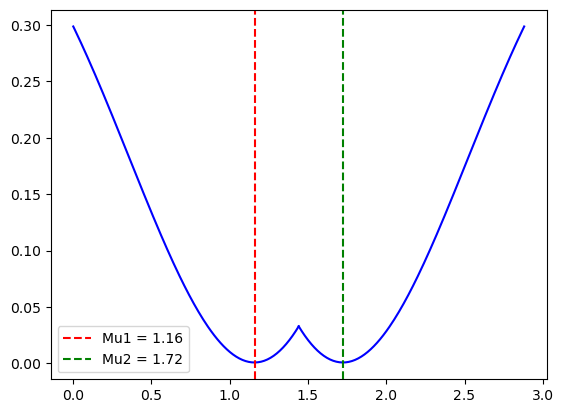

In [4]:
from scipy.stats import skellam

PL2025_df = pd.read_csv("Data/PL2025.csv")

row = PL2025_df.iloc[2]

# Removing vig
U25 = 1/row['P<2.5'] / (1/row['P<2.5'] + 1/row['P>2.5'])
draw_prob = 1/row['PSD'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
win_prob = 1/row['PSH'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
loss_prob = 1/row['PSA'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])

def poisson_difference_function(mu):
    return np.abs(np.exp(-mu)*(0.5*mu**2 + mu + 1) - U25)
optimal_mu = golden(poisson_difference_function, brack=(0, 10))

mu1 = mu2 = optimal_mu / 2

def skellam_loss(mu1, mu2):
    draw_loss = (skellam.pmf(0, mu1, mu2) - draw_prob) ** 2
    win_loss = ((1 - skellam.cdf(0, mu1, mu2)) - win_prob) ** 2
    loss_loss = (skellam.cdf(-1, mu1, mu2) - loss_prob) ** 2
    return draw_loss + win_loss + loss_loss

mu_optimisation = pd.DataFrame(columns=["Mu1", "Mu2", "Loss"])
mu_optimisation = pd.concat([mu_optimisation, pd.DataFrame([{"Mu1": mu1, "Mu2": mu2, "Loss": skellam_loss(mu2, mu1)}])], ignore_index=True)

tick = 0.01
for tick in np.arange(0, mu1, tick):
    mu1_new = mu1 - tick
    mu2_new = mu2 + tick
    if win_prob > loss_prob:
        new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu2_new, mu1_new)}])
    else:
        new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu1_new, mu2_new)}])
    mu_optimisation = pd.concat([mu_optimisation, new_row], ignore_index=True)

plt.plot(mu_optimisation['Mu1'], mu_optimisation['Loss'], color='b')
plt.axvline(mu_optimisation['Mu1'].iloc[np.argmin(mu_optimisation['Loss'])], linestyle='--', color='r', label=f"Mu1 = {mu_optimisation['Mu1'].iloc[np.argmin(mu_optimisation['Loss'])]:.2f}")
plt.plot(mu_optimisation['Mu2'], mu_optimisation['Loss'], color='b')
plt.axvline(mu_optimisation['Mu2'].iloc[np.argmin(mu_optimisation['Loss'])], linestyle='--', color='g', label=f"Mu2 = {mu_optimisation['Mu2'].iloc[np.argmin(mu_optimisation['Loss'])]:.2f}")
plt.legend(loc='best')
plt.show()

### **4.1.3 Derivation Test On Real Data**

Finally, we can test this data on real games and sanity check them. I will purposely be selecting games I know more about as I have a better understanding of what reasonable $\lambda$ values look like for each team.

**Game 1: Liverpool vs. Bournemouth**

**Configured into a function**

In [5]:
def calculate_lambdas(row):
    # Remove vig
    U25 = 1/row['P<2.5'] / (1/row['P<2.5'] + 1/row['P>2.5'])
    draw_prob = 1/row['PSD'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
    win_prob = 1/row['PSH'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
    loss_prob = 1/row['PSA'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])

    def poisson_difference_function(mu):
        return np.abs(np.exp(-mu)*(0.5*mu**2 + mu + 1) - U25)
    optimal_mu = golden(poisson_difference_function, brack=(0, 100))

    mu_centered = optimal_mu / 2

    def skellam_loss(mu1, mu2):
        draw_loss = (skellam.pmf(0, mu1, mu2) - draw_prob) ** 2
        win_loss = ((1 - skellam.cdf(0, mu1, mu2)) - win_prob) ** 2
        loss_loss = (skellam.cdf(-1, mu1, mu2) - loss_prob) ** 2
        return draw_loss + win_loss + loss_loss

    mu_optimisation = pd.DataFrame(columns=["Mu1", "Mu2", "Loss"])
    mu_optimisation = pd.concat([mu_optimisation, pd.DataFrame([{"Mu1": mu1, "Mu2": mu2, "Loss": skellam_loss(mu_centered, mu_centered)}])], ignore_index=True)

    resolution = 0.001
    for resolution in np.arange(0, mu1, resolution):
        mu1_new = mu1 - resolution
        mu2_new = mu2 + resolution
        if win_prob > loss_prob:
            new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu2_new, mu1_new)}])
        else:
            new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu1_new, mu2_new)}])
        mu_optimisation = pd.concat([mu_optimisation, new_row], ignore_index=True)

    if win_prob > loss_prob:
        team1 = row['AwayTeam']
        team2 = row['HomeTeam']
    else:
        team1 = row['HomeTeam']
        team2 = row['AwayTeam']
    
    plt.plot(mu_optimisation['Mu1'], mu_optimisation['Loss'], color='b')
    plt.plot(mu_optimisation['Mu1'].iloc[np.argmin(mu_optimisation['Loss'])], min(mu_optimisation['Loss']), marker='o', color='r', label=f"{team1} XG = {mu_optimisation['Mu1'].iloc[np.argmin(mu_optimisation['Loss'])]:.2f}")
    plt.plot(mu_optimisation['Mu2'], mu_optimisation['Loss'], color='b')
    plt.plot(mu_optimisation['Mu2'].iloc[np.argmin(mu_optimisation['Loss'])], min(mu_optimisation['Loss']), marker='o', color='g', label=f"{team2} XG = {mu_optimisation['Mu2'].iloc[np.argmin(mu_optimisation['Loss'])]:.2f}")
    plt.title(f"{row['HomeTeam']} vs. {row['AwayTeam']}")
    plt.legend(loc='best')
    plt.show()

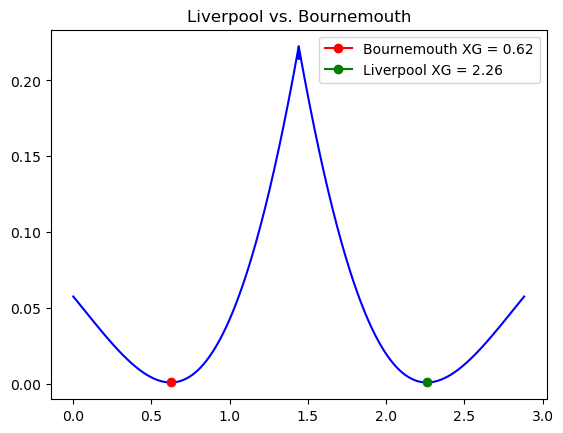

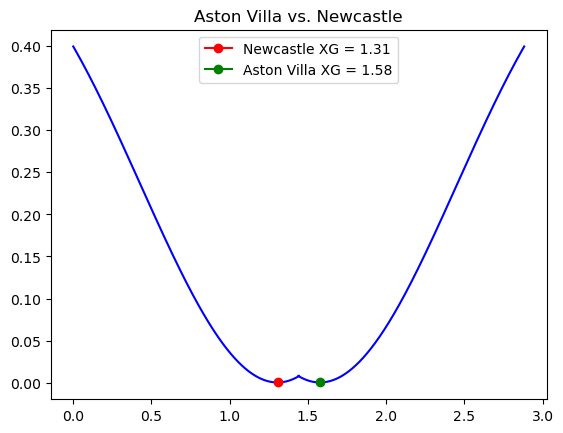

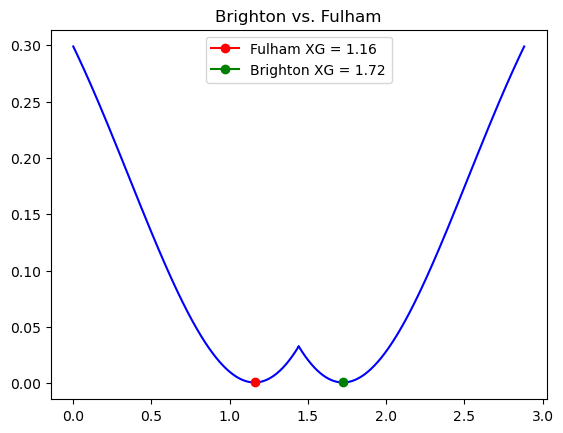

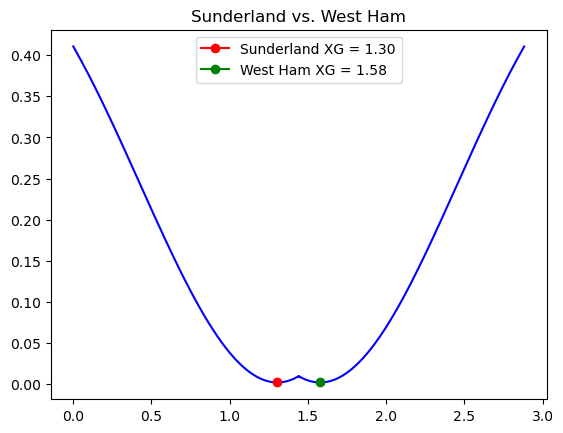

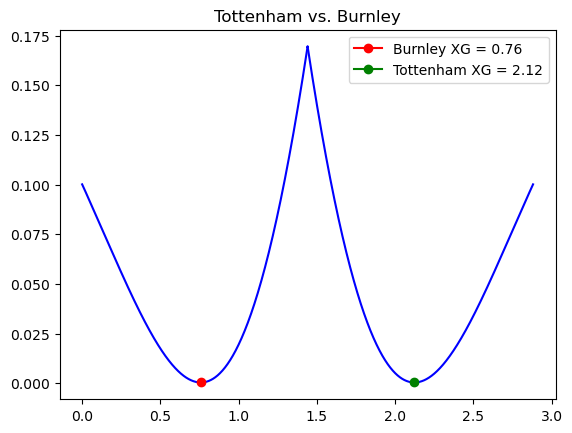

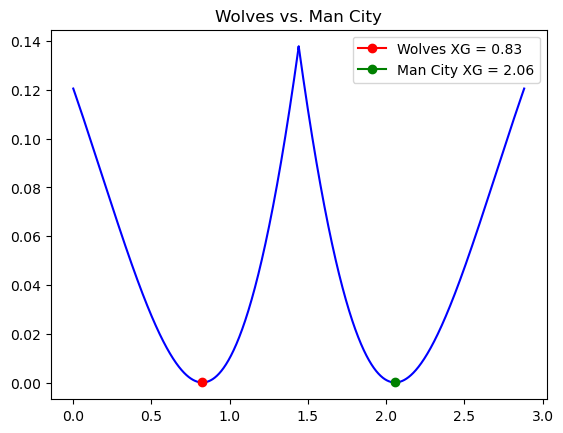

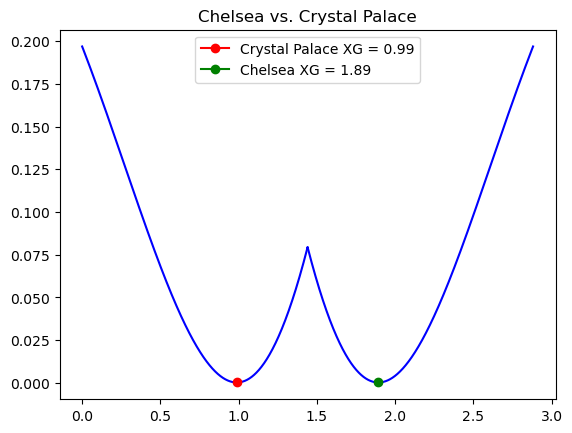

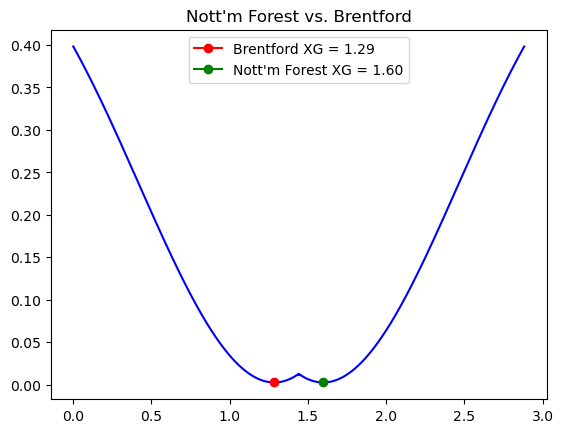

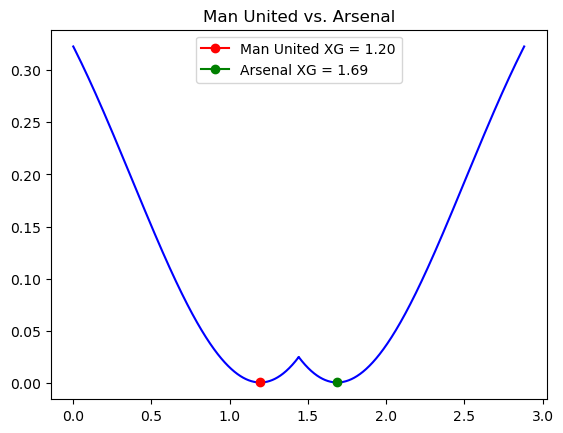

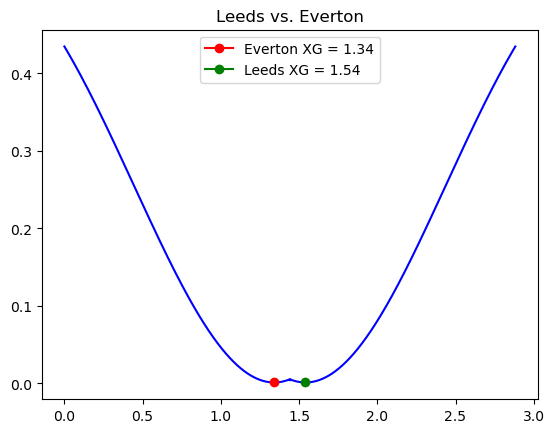

In [6]:
for index, row in PL2025_df.iloc[:10].iterrows():
    calculate_lambdas(row)

In [64]:
def lambda_calculation(df):
    """
    Takes dataframe where there is one team per row.
    """
    # Remove vig
    U25 = 1/row['P<2.5'] / (1/row['P<2.5'] + 1/row['P>2.5'])
    draw_prob = 1/row['PSD'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
    win_prob = 1/row['PSH'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])
    loss_prob = 1/row['PSA'] / (1/row['PSD'] + 1/row['PSH'] + 1/row['PSA'])

    def poisson_difference_function(mu):
        return np.abs(np.exp(-mu)*(0.5*mu**2 + mu + 1) - U25)
    optimal_mu = golden(poisson_difference_function, brack=(0, 100))

    mu_centered = optimal_mu / 2

    def skellam_loss(mu1, mu2):
        draw_loss = (skellam.pmf(0, mu1, mu2) - draw_prob) ** 2
        win_loss = ((1 - skellam.cdf(0, mu1, mu2)) - win_prob) ** 2
        loss_loss = (skellam.cdf(-1, mu1, mu2) - loss_prob) ** 2
        return draw_loss + win_loss + loss_loss

    mu_optimisation = pd.DataFrame(columns=["Mu1", "Mu2", "Loss"])
    mu_optimisation = pd.concat([mu_optimisation, pd.DataFrame([{"Mu1": mu1, "Mu2": mu2, "Loss": skellam_loss(mu_centered, mu_centered)}])], ignore_index=True)

    resolution = 0.001
    for resolution in np.arange(0, mu1, resolution):
        mu1_new = mu1 - resolution
        mu2_new = mu2 + resolution
        if win_prob > loss_prob:
            new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu2_new, mu1_new)}])
        else:
            new_row = pd.DataFrame([{"Mu1": mu1_new, "Mu2": mu2_new, "Loss": skellam_loss(mu1_new, mu2_new)}])
        mu_optimisation = pd.concat([mu_optimisation, new_row], ignore_index=True)

    lambda1 = mu_optimisation['Mu1'].iloc[np.argmin(mu_optimisation['Loss'])]
    lambda2 = mu_optimisation['Mu2'].iloc[np.argmin(mu_optimisation['Loss'])]

    if row['Location'] == "Home":
        if win_prob > loss_prob:
            return lambda2
        else:
            return lambda1
    else:
        if win_prob > loss_prob:
            return lambda1
        else:
            return lambda2


def target_vector_construction(df):
    "Takes dataframe with one team per row and outputs a dataframe with Match ID and XG"
    target_vector_df = pd.DataFrame(columns=["Match ID", "Projected XG"])

    for index, row in df.iterrows():
        


In [61]:
def construct_dataset(df)

    home_df = df.copy()
    away_df = df.copy()

    home_df.rename(columns = {"HomeTeam": "Team", "AwayTeam": "Opponent"}, inplace=True)
    home_df['Location'] = "Home"
    away_df.rename(columns = {"AwayTeam": "Team", "HomeTeam": "Opponent"}, inplace=True)
    away_df['Location'] = "Away"

    cleaned_df = pd.concat([home_df, away_df])
    cleaned_df["Date"] = pd.to_datetime(cleaned_df["Date"], format="%d/%m/%Y")
    cleaned_df["Time"] = pd.to_datetime(cleaned_df["Time"])
    cleaned_df = cleaned_df.sort_values(by=["Date", "Time"], ascending=[True, True])

    cleaned_df = 

PL2025_df = pd.read_csv("Data/PL2025.csv")

0     Home
0     Away
1     Home
1     Away
2     Home
      ... 
37    Away
38    Home
38    Away
39    Home
39    Away
Name: Location, Length: 80, dtype: object

In [40]:
PL2025_df

,Div,Date,Time,Team,Opponent,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA,Location
0,E0,15/08/2025,20:00,Liverpool,Bournemouth,4,2,H,1,0,...,1.78,2.07,1.85,2.03,1.88,1.94,1.76,2.14,1.86,Away
1,E0,16/08/2025,12:30,Aston Villa,Newcastle,0,0,D,0,0,...,1.80,2.02,1.89,2.06,1.80,1.95,1.74,2.14,1.86,Away
2,E0,16/08/2025,15:00,Brighton,Fulham,1,1,D,0,0,...,2.03,1.93,2.00,1.84,2.03,1.80,1.96,1.91,2.08,Away
3,E0,16/08/2025,15:00,Sunderland,West Ham,3,0,H,0,0,...,1.90,1.97,1.95,1.95,1.94,1.86,1.78,2.02,1.97,Away
4,E0,16/08/2025,15:00,Tottenham,Burnley,3,0,H,1,0,...,1.88,1.99,1.93,1.98,1.91,1.88,1.83,2.07,1.92,Away
5,E0,16/08/2025,17:30,Wolves,Man City,0,4,A,0,2,...,1.88,2.07,1.86,2.04,1.88,1.91,1.81,2.05,1.94,Away
6,E0,17/08/2025,14:00,Chelsea,Crystal Palace,0,0,D,0,0,...,2.00,1.74,2.21,1.85,2.03,1.79,1.97,1.88,2.12,Away
7,E0,17/08/2025,14:00,Nott'm Forest,Brentford,3,1,H,3,0,...,1.98,2.18,1.76,1.91,1.98,1.86,1.89,1.96,2.03,Away
8,E0,17/08/2025,16:30,Man United,Arsenal,0,1,A,0,1,...,1.98,1.91,2.01,1.93,1.98,1.86,1.89,2.00,1.99,Away
9,E0,18/08/2025,20:00,Leeds,Everton,1,0,H,0,0,...,1.80,2.02,1.90,2.05,1.86,1.91,1.78,2.14,1.86,Away


# **5. Simulation Calls**

# **6. Reflection**

# **7. Archive**

Some of the tested theories I had which I don't wanna let go!

# **Visualisations**

In [9]:
PL2025_df = pd.read_csv("PL2025.csv")

In [12]:
for col in PL2025_df.columns: print(columns)

Div
Date
Time
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
Referee
HS
AS
HST
AST
HF
AF
HC
AC
HY
AY
HR
AR
B365H
B365D
B365A
BFDH
BFDD
BFDA
BMGMH
BMGMD
BMGMA
BVH
BVD
BVA
BWH
BWD
BWA
CLH
CLD
CLA
LBH
LBD
LBA
PSH
PSD
PSA
MaxH
MaxD
MaxA
AvgH
AvgD
AvgA
BFEH
BFED
BFEA
B365>2.5
B365<2.5
P>2.5
P<2.5
Max>2.5
Max<2.5
Avg>2.5
Avg<2.5
BFE>2.5
BFE<2.5
AHh
B365AHH
B365AHA
PAHH
PAHA
MaxAHH
MaxAHA
AvgAHH
AvgAHA
BFEAHH
BFEAHA
B365CH
B365CD
B365CA
BFDCH
BFDCD
BFDCA
BMGMCH
BMGMCD
BMGMCA
BVCH
BVCD
BVCA
BWCH
BWCD
BWCA
CLCH
CLCD
CLCA
LBCH
LBCD
LBCA
PSCH
PSCD
PSCA
MaxCH
MaxCD
MaxCA
AvgCH
AvgCD
AvgCA
BFECH
BFECD
BFECA
B365C>2.5
B365C<2.5
PC>2.5
PC<2.5
MaxC>2.5
MaxC<2.5
AvgC>2.5
AvgC<2.5
BFEC>2.5
BFEC<2.5
AHCh
B365CAHH
B365CAHA
PCAHH
PCAHA
MaxCAHH
MaxCAHA
AvgCAHH
AvgCAHA
BFECAHH
BFECAHA


In [14]:
U25_raw = PL2025_df['P<2.5'].iloc[0]
O25_raw = PL2025_df['P>2.5'].iloc[0]

U25 = U25_raw / ((U25_raw + O25_raw))
O25 = O25_raw / ((U25_raw + O25_raw))

print(f"Under 2.5 = {U25}")
print(f"Over 2.5 = {O25}")

Under 2.5 = 0.7041036717062634
Over 2.5 = 0.2958963282937365


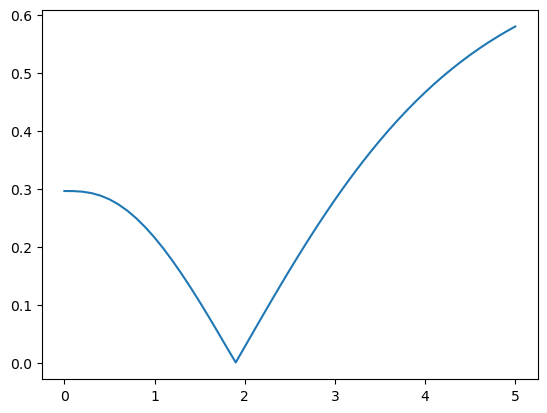

In [24]:
lam_list = np.linspace(0, 5, 51)
p_val = []

for lam in lam_list:
    p_val.append(np.abs(np.exp(-lam)*(0.5*lam**2 + lam + 1) - U25))

plt.plot(lam_list, p_val)

In [66]:
U25_raw = PL2025_df['P<2.5'].iloc[4]
O25_raw = PL2025_df['P>2.5'].iloc[4]

U25 = U25_raw / ((U25_raw + O25_raw))
O25 = O25_raw / ((U25_raw + O25_raw))

def lam_function(lam):
    return np.abs(np.exp(-lam)*(0.5*lam**2 + lam + 1) - U25)

In [67]:
golden(lam_function)

2.4566232064941707